In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import os

In [2]:
#Set the current working directory / or manually type-in
cwdir = os.getcwd() #'/Users/jane_hsieh/Library/CloudStorage/OneDrive-國立陽明交通大學/Data Science 
os.chdir(cwdir)
print(cwdir)

#indicate the directory path for the fold where 4 MNIST data are located (default: in cwdir)
data_dir = './MNIST Database'

/work/files/workspace


# 0. Input Data: MNIST

In [3]:
#1.1 Input training/testing data and their labels (X, y)
from mlxtend.data import loadlocal_mnist #make sure installed via conda
Train_X, Train_y = loadlocal_mnist(
        images_path=data_dir+'/train-images-idx3-ubyte', 
        labels_path=data_dir+'/train-labels-idx1-ubyte')

Test_X, Test_y = loadlocal_mnist(
        images_path=data_dir+'/t10k-images-idx3-ubyte', 
        labels_path=data_dir+'/t10k-labels-idx1-ubyte')

## Transform into DataFrame form
Train_X = pd.DataFrame(Train_X); print(f"shape of Train_X: {Train_X.shape}")
Train_y = pd.DataFrame(Train_y, columns = ["digit"]); print(f'shape of Train_y: {Train_y.shape}')
#Test_X = pd.DataFrame(Test_X)
#Test_y = pd.DataFrame(Test_y, columns = ["digit"])

'''
## Inspenct the frequency of each class (digit 0-9)
unique_elements, counts_elements = np.unique(Train_y, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Train_N = Train_X.shape[0]
print("Percentage of each class of Train_y data: \n {}".format(np.asarray((unique_elements, counts_elements/Train_N))))
'''
p = Train_X.shape[1]
width = int(math.sqrt(p))
shape =  (width, width); print(f"i.e., size of image of Train_X: {shape}")

shape of Train_X: (60000, 784)
shape of Train_y: (60000, 1)
i.e., size of image of Train_X: (28, 28)


# 1. Experiments of Anomaly Detection

## 1.1 ANN modeling, prediction & Evaluation


In [4]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Define ANN models
def ANN(k):
    # Start with a sequential model
    autoencoder = Sequential()

    # Add a dense layer (first layer) with input the original image pixels and neurons the encoded representation
    autoencoder.add(Dense(k, input_shape=(p, ), activation="relu")) #for tabular data X(shape=(N, n_cols)), input_shape=(n_cols, )

    # Add an output layer with as many neurons as the orginal image pixels
    autoencoder.add(Dense(p, activation = "sigmoid"))

    # Compile your model with adadelta
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'accuracy'])
    autoencoder.summary()
    return autoencoder


def ANN2(k):
    # Start with a sequential model
    autoencoder = Sequential()

    # Add a dense layer (first layer) with input the original image pixels and neurons the encoded representation
    autoencoder.add(Dense(k, input_shape=(p, ), activation="relu", 
                          activity_regularizer = regularizers.l1(10e-5))) #for tabular data X(shape=(N, n_cols)), input_shape=(n_cols, )

    # Add an output layer with as many neurons as the orginal image pixels
    autoencoder.add(Dense(p, activation = "sigmoid"))

    # Compile your model with adadelta
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'accuracy'])
    autoencoder.summary()
    return autoencoder


2023-04-11 04:01:11.553645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 04:01:11.553668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# Prediction dichotomization
def predict_binary(AD_scores, threshold = 0.05):
    """
    dichotomize largest (threshold*100)% of AD_score as anomalies (pred_y = 1), the rest as normal data (pred_y=0)
    Input: 
        AD_scores: outlier scores, len = sample size N
    Output:
        pred_y: binary data whether each case(row) of X is anomaly or not
    """    
    N = len(AD_scores)    
    N_A = math.ceil(N * threshold)

    #calculate the suspicious_index and suspicious_score    
    temp =sorted(enumerate(AD_scores), key=operator.itemgetter(1), reverse=True) 
    #return list of ([implicit] index, value) from largest to lowest
    temp = pd.DataFrame(temp)  #2nd column of temp is the d values ranking from biggest to lowest;
    s_index = temp.iloc[:,0]  #1st of that is the corresponding indices(positions) of d
    
    pred_y = np.zeros(N)
    pred_y[ s_index[:N_A]] = 1
    return pred_y

# Evaluation
def FPrate(y, y_pred):
    N1 = y[y == 1].sum()
    N0 = len(y) - N1
    cm = confusion_matrix(y, y_pred)
    return  cm[0, 1]/N0

def Classification_metrics(y, AD_binary):
    """
    Input: 
        y: true y (binary: 0, 1)
        AD_binary: pred_y, binary data whether each case(row) of X is anomaly or not
    Output: Binary classification metric, cm, TN, acc, f1, precision, recall     
    """
    cm = confusion_matrix(y, AD_binary);print("confusion_matrix:\n{}".format(cm))
    acc = accuracy_score(y, AD_binary);print("accuarcy: {}".format(acc))
    TN = 1- FPrate(y, AD_binary).values[0];print("TN rate: {}".format(TN))        
    recall = recall_score(y, AD_binary);print("recall score: {}".format(recall))
    f1 = f1_score(y, AD_binary);print("f1 score: {}".format(f1))
    precision = precision_score(y, AD_binary);print("precision score: {}".format(precision))
    dic = {"cm": cm, "accuracy": acc, "TNrate": TN, "f1": f1, "precision": precision, "recall": recall}
    return dic

## 1.2 Experiments

In [6]:
import time
import operator
import random
random.seed(a=0) #fix a to a specific number, so the experiment can be replicated <--------------

### Parameter settings - customized
- Define normal & abnormal digit 
- Sample size (default: 95% normal data vs 5% abnormal data)

In [7]:
## Define normal diget: d_normal
d_normal = 0  #<----------------------------------------- you can define a number as normal
N0 = 5700
Train_X_0 = Train_X[Train_y.values == d_normal]

## Define abnormal digit: d_ab (1~9)
d_ab = 1      #<----------------------------------------- you can define a number as anomalies other than d_normal
N_ab = 300
Train_X_ab = Train_X[Train_y.values == d_ab]

N = N0 + N_ab

# For experiment design and anomaly detection classification
m = 1; print("{m}-st model selected") # 1 or 2
n_iter = 5 #{iterations}
#ks = [3]
ks = list(range(1,11))  #{hiddedn units}
batch_size = 60
epochs = 30
threshold = 0.05

{m}-st model selected


In [8]:
##Set the output folder name (fold should be put subordinate to cwdir)
out_folder = f'Out_{d_normal}vs{d_ab}'
out_dir = os.path.join(cwdir,out_folder)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
# output location
outF_E = open(os.path.join(out_dir, f"Evaluation_Error_{d_normal}vs{d_ab}.csv"), "a", newline='\n')
outF_D = open(os.path.join(out_dir, f"Evaluation_Distance_{d_normal}vs{d_ab}.csv"), "a", newline='\n')

iteration 0,	 k=1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 dense_1 (Dense)             (None, 784)               1568      
                                                                 
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 785       
                                                                 
 dense_3 (Dense)             (None, 784)               1568      
                                                                 
Total params: 

2023-04-03 17:33:50.285264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-03 17:33:50.285290: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 17:33:50.285306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9d33d2a6-ccd2-426f-984e-ba6bdb2205c4): /proc/driver/nvidia/version does not exist
2023-04-03 17:33:50.285496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
100/100 [==============================] - 0s 1ms/step - loss: 0.1603 - mae: 0.3718 - accuracy: 0.0018
Epoch 2/30
100/100 [==============================] - 0s 990us/step - loss: 0.0728 - mae: 0.1962 - accuracy: 3.3333e-04
Epoch 3/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0671 - mae: 0.1684 - accuracy: 5.0000e-04
Epoch 4/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0660 - mae: 0.1602 - accuracy: 0.0010
Epoch 5/30
100/100 [==============================] - 0s 993us/step - loss: 0.0655 - mae: 0.1564 - accuracy: 0.0018
Epoch 6/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0651 - mae: 0.1540 - accuracy: 3.3333e-04
Epoch 7/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1523 - accuracy: 0.0013
Epoch 8/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0643 - mae: 0.1511 - accuracy: 5.0000e-04
Epoch 9/30
100/100 [==============================] - 0s 966us/step 

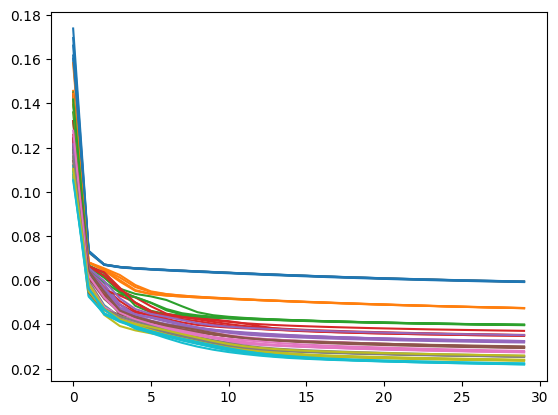

In [9]:
for it in range(n_iter):
    #1. Random sample data (X, y)++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ## Random select normal data with sample size = N0
    indices_select = random.sample( list(range(0,Train_X_0.shape[0])),  N0 ) 
    Train_X_0_sel = Train_X_0.iloc[indices_select].copy()  
    Train_y_0 = pd.DataFrame(np.zeros(N0), columns=['Is_Ab'])#Train_y[Train_y.values == d_normal][:N0] 
    Train_y_0.index = Train_X_0_sel.index
    
    ## Random select abnormal data with sample size = N0 + N_ab
    indices_select = random.sample( list(range(0,Train_X_ab.shape[0])),  N_ab ) 
    Train_X_ab_sel = Train_X_ab.iloc[indices_select]
    Train_y_ab = pd.DataFrame(np.ones(N_ab), columns=['Is_Ab'])#Train_y[Train_y.values == d_ab][:N_ab ] 
    Train_y_ab.index = Train_X_ab_sel.index
    
    ## Selected data for analysis
    X = Train_X_0_sel.append(Train_X_ab_sel) # N = 5700 + 300 = 6000
    y = Train_y_0.append(Train_y_ab)
    ### shuffle rows of (X, y)
    id_shuffle = X.index.tolist()
    random.shuffle(id_shuffle)#;print(id_shuffle[:10])
    #print(id_shuffle[0])
    id_shuffle = pd.Index(id_shuffle)    
    X = X.loc[id_shuffle, :]
    y = y.loc[id_shuffle]
    ### Feature Scaling
    X = X/255
    
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    #print("Frequency of unique values of the said array:")
    #print( np.asarray((unique_elements, counts_elements)) )
    del Train_X_0_sel, Train_X_ab_sel, Train_y_0, Train_y_ab, indices_select    

    
    for k in ks:
        print(f'iteration {it},\t k={k}')
        start = time.time() #<<<!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        #2. Dimension Reduction & reconstruction: Autoencoder++++++++++++++++++++++++++++++++++++
        #2.2. Autoencoder modeling and fitting
        models = {"1": ANN(k), "2": ANN2(k)}
        autoencoder = models[str(m)] #ANN(k) or ANN2(k)
        model_history = autoencoder.fit(X, X, 
                                        batch_size = batch_size,epochs = epochs, 
                                        verbose = 1, shuffle = True)
        # training history monitoring
        train_history = pd.DataFrame(model_history.history)
        train_history['epoch'] = list(range(epochs))
        train_history.loss.plot()
        
        # Fitting results 
        ## reconstructed X - shape = (N, p)
        X_pred = autoencoder.predict(X) 

        ## Encoder (first half of Autoencoder)
        encoder = Sequential() # Build your encoder by using the first layer of your autoencoder
        encoder.add(autoencoder.layers[0]) #build structure of 1st layer (input->first hidden layer) onto raw model
        encodings = encoder.predict(X) # Encode the images 
        encodings_m = encodings.mean(axis=0) #mean of all encodings
        #print(encodings_m.shape)
        
        ## Efficiency
        end1 = time.time()
        t_it1 = end1 - start
        
        #3. For Anomaly Scores Calculation - Reconstruction Error ++++++++++++++++++++++++++++++ 
        for l in range(1,3):
            end1 = time.time()
            print(f"Reconstruction Error - L{l}")
            #3.1 Reconstruction Error - L1 vs L2
            AD_scores = np.linalg.norm(X - X_pred, ord=l, axis=1) #default: ord=None (2-norm)
            #print(len(AD_scores))
            #plt.boxplot(AD_scores)

            ##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
            AD_binary = predict_binary(AD_scores, threshold = threshold)
            AD_binary = pd.Series(AD_binary, index = X.index)        
        
            # 3.2 Ad-hoc Evaluations 
            ## Efficacy
            metrics = Classification_metrics(y, AD_binary)
            ## Efficiency
            end2 = time.time()
            t_it2 = end2 - end1 #unit: sec.
            
            #3.3 Output
            record = pd.DataFrame([{"ANN_model": m, "digit_Ab": d_ab, 
                                    "iteration": it, "k": k, "L": l,
                                    "accuracy": metrics["accuracy"],
                                    "TNrate": metrics["TNrate"], 
                                    "recall": metrics["recall"],
                                    "f1": metrics["f1"], 
                                    "precision": metrics["precision"], "time": t_it1 + t_it2,
                                    "metric": 'Construction Error'
                                }])                 
            #print(outF_E.tell())
            record.to_csv(outF_E,mode='a',header = outF_E.tell()==0, index=False)
            del metrics, record, AD_scores, AD_binary
            
        del l, X_pred
              
        
        #4. For Anomaly Scores Calculation - Centered Distance in Projection space ++++++++++
        for l in range(1,3):
            end1 = time.time()
            print(f"Centered Distance in Projection space - L{l}")            
            #4.1 Centered Distance in Projection/representation space  - L1 vs L2
            AD_scores = np.linalg.norm(encodings - encodings_m, ord=l, axis=1)
            #print(len(AD_scores))
            #plt.boxplot(AD_scores)

            ##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
            AD_binary = predict_binary(AD_scores, threshold = threshold)
            AD_binary = pd.Series(AD_binary, index = X.index)        

            # 4.2 Ad-hoc Evaluations 
            ## Efficacy
            metrics = Classification_metrics(y, AD_binary)
            ## Efficiency
            end2 = time.time()
            t_it2 = end2 - end1 #unit: sec.            
            #4.3 Output
            record = pd.DataFrame([{"ANN_model": m, "digit_Ab": d_ab, 
                                    "iteration": it, "k": k, "L": l,
                                    "accuracy": metrics["accuracy"],
                                    "TNrate": metrics["TNrate"], 
                                    "recall": metrics["recall"],
                                    "f1": metrics["f1"], 
                                    "precision": metrics["precision"], "time": t_it1 + t_it2,
                                    "metric": 'Projection Distance'
                                }])                 
            #print(outF_D.tell())
            record.to_csv(outF_D,mode='a',header = outF_D.tell()==0, index=False)
            del metrics, record, AD_scores, AD_binary
            
        del l, encodings, encodings_m, models #, autoencoder
        
    #del X, y 
    
outF_E.close()
outF_D.close()

# 2. Result Summariztion

## 2.1 Result Visualization

In [8]:

m = 1
d_normal = 0
d_ab = 1
ks = list(range(1,11))  #{hiddedn units}
out_folder = f'Out_{d_normal}vs{d_ab}'
out_dir = os.path.join(cwdir,out_folder);out_dir

k_max = 10

In [9]:
Record_E = pd.read_csv(os.path.join(out_dir, f"Evaluation_Error_{d_normal}vs{d_ab}.csv"))
Record_D = pd.read_csv(os.path.join(out_dir, f"Evaluation_Distance_{d_normal}vs{d_ab}.csv"))
#Record_E['metric'] = 'Construction Error'
#Record_D['metric'] = 'Projection Distance'
Record = pd.concat([Record_E, Record_D], axis = 0)


Record_agg = Record.groupby(['ANN_model','digit_Ab','metric', 'L', 'k']).agg([np.mean, np.std])
print('Results of Construction Error:\n')
Record_agg.loc[(m, d_ab, 'Construction Error')].head(10)


Results of Construction Error:



iteration            accuracy  ... precision      time          
          mean       std      mean  ...       std      mean       std
L k                                 ...                              
1 1        2.0  1.581139  0.941133  ...  0.025011  4.341210  0.210860
  2        2.0  1.581139  0.945600  ...  0.055847  4.690180  0.050387
  3        2.0  1.581139  0.931133  ...  0.184851  4.706885  0.095258
  4        2.0  1.581139  0.957933  ...  0.114828  4.714561  0.032511
  5        2.0  1.581139  0.917267  ...  0.160855  4.696565  0.026652
  6        2.0  1.581139  0.907533  ...  0.024106  4.678570  0.038670
  7        2.0  1.581139  0.909467  ...  0.010698  4.788620  0.140614
  8        2.0  1.581139  0.906600  ...  0.031127  4.696874  0.069801
  9        2.0  1.581139  0.907867  ...  0.015019  4.813728  0.060479
  10       2.0  1.581139  0.908000  ...  0.019437  4.990395  0.051406

[10 rows x 14 columns]

In [10]:
print('Results of Projection Distanc:\n')
Record_agg.loc[(m, d_ab, 'Projection Distance')].head(10)

Results of Projection Distanc:



iteration            accuracy  ... precision      time          
          mean       std      mean  ...       std      mean       std
L k                                 ...                              
1 1        2.0  1.581139  0.948800  ...  0.037830  4.324264  0.211045
  2        2.0  1.581139  0.952733  ...  0.076645  4.674629  0.050003
  3        2.0  1.581139  0.976400  ...  0.114562  4.691206  0.096290
  4        2.0  1.581139  0.964800  ...  0.115533  4.698963  0.031532
  5        2.0  1.581139  0.958667  ...  0.202389  4.680937  0.026383
  6        2.0  1.581139  0.943067  ...  0.270343  4.662945  0.037358
  7        2.0  1.581139  0.958600  ...  0.226095  4.772784  0.139575
  8        2.0  1.581139  0.962400  ...  0.210098  4.681565  0.067265
  9        2.0  1.581139  0.952133  ...  0.168335  4.797203  0.059341
  10       2.0  1.581139  0.943467  ...  0.145193  4.975377  0.049897

[10 rows x 14 columns]

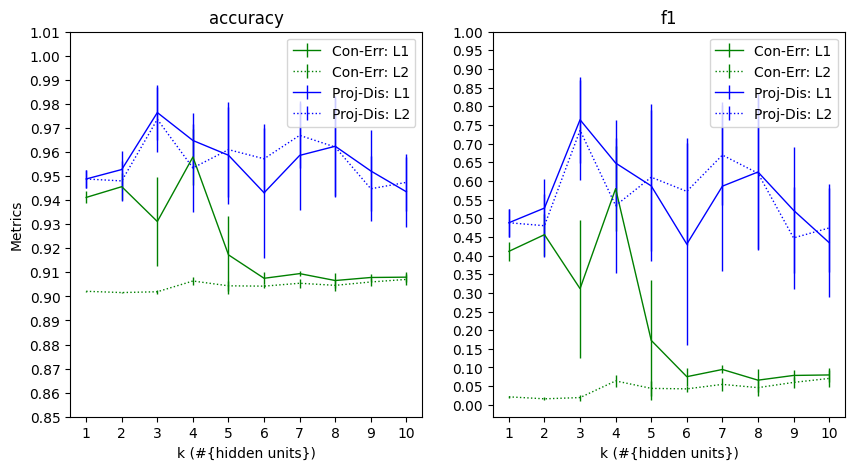

In [11]:
## Acc ---------------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(10,5))#, sharey=True
#ax2 = ax.twinx()

x_axis = ks[:k_max] 

Metrics = {1: 'f1', 0: 'accuracy'}
Yticks = {1: np.arange(0, 1.01, 0.05), 0: np.arange(0.85, 1.01, 0.01)}

for i, eva in Metrics.items():

    # Construction Error L1 vs L2
    y_axis = Record_agg.loc[(m, d_ab, 'Construction Error', 1),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Construction Error', 1),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='-', c='g', lw=1, label='Con-Err: L1')

    y_axis = Record_agg.loc[(m, d_ab, 'Construction Error', 2),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Construction Error', 2),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='dotted', lw=1, c='g', label='Con-Err: L2')

    # Projection Distance L1 vs L2
    y_axis = Record_agg.loc[(m, d_ab, 'Projection Distance', 1),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Projection Distance', 1),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='-', c='blue', lw=1, label='Proj-Dis: L1')

    y_axis = Record_agg.loc[(m, d_ab, 'Projection Distance', 2),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Projection Distance', 2),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='dotted', lw=1, c='blue', label='Proj-Dis: L2')

    ax[i].set_xticks(x_axis)
    ax[i].set_yticks(Yticks[i])
    ax[i].set_xlabel("k (#{hidden units})")
    ax[i].legend() #loc='middle right'
    ax[i].set_title(eva)
ax[0].set_ylabel("Metrics")


plt.savefig(os.path.join(out_dir, f"Evaluation_ANN{m}_Acc_F1_{d_normal}vs{d_ab}.png"), transparent=True)
plt.show()

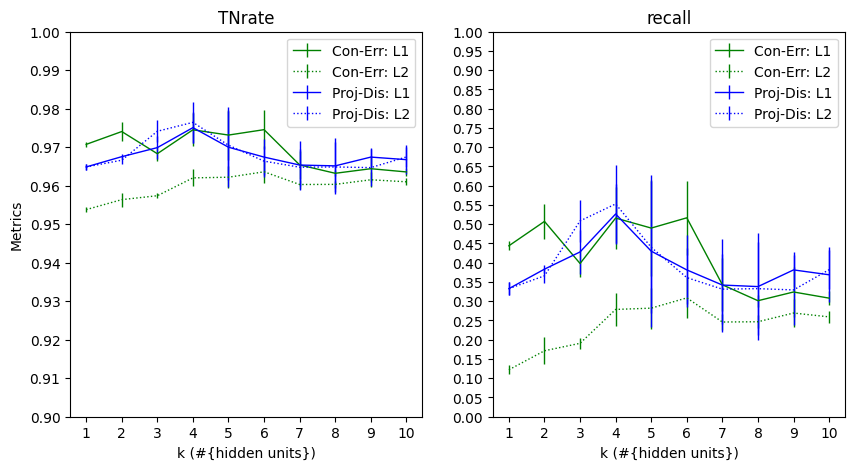

In [14]:
## Acc ---------------------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(10,5))# sharey=True
#ax2 = ax.twinx()

x_axis = ks[:k_max] 

Metrics = {1: 'recall', 0: 'TNrate'}
Yticks = {1: np.arange(0, 1.01, 0.05), 0: np.arange(0.90, 1.01, 0.01)}

for i, eva in Metrics.items():

    # Construction Error L1 vs L2
    y_axis = Record_agg.loc[(m, d_ab, 'Construction Error', 1),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Construction Error', 1),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='-', c='g', lw=1, label='Con-Err: L1')

    y_axis = Record_agg.loc[(m, d_ab, 'Construction Error', 2),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Construction Error', 2),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='dotted', lw=1, c='g', label='Con-Err: L2')

    # Projection Distance L1 vs L2
    y_axis = Record_agg.loc[(m, d_ab, 'Projection Distance', 1),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Projection Distance', 1),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='-', c='blue', lw=1, label='Proj-Dis: L1')

    y_axis = Record_agg.loc[(m, d_ab, 'Projection Distance', 2),(eva, 'mean')][:k_max]
    yerr = Record_agg.loc[(m, d_ab, 'Projection Distance', 2),(eva, 'std')][:k_max]
    ax[i].errorbar(x_axis, y_axis , yerr=yerr, ls='dotted', lw=1, c='blue', label='Proj-Dis: L2')


    ax[i].set_xticks(x_axis)
    ax[i].set_yticks(Yticks[i])
    ax[i].set_xlabel("k (#{hidden units})")
    ax[i].legend() #loc='middle right'
    ax[i].set_title(eva)
ax[0].set_ylabel("Metrics")


plt.savefig(os.path.join(out_dir, f"Evaluation_ANN{m}_TN_Recall_{d_normal}vs{d_ab}.png"), transparent=True)
plt.show()